# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Exploratory Analysis

## portfolio

First step we want to clean up channels column in portfolio

ref: https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

In [5]:
# they are already in list format so we can directly expand them into their own columns
for i, l in enumerate(portfolio.channels):
    print("list",i,"is",type(l))

list 0 is <class 'list'>
list 1 is <class 'list'>
list 2 is <class 'list'>
list 3 is <class 'list'>
list 4 is <class 'list'>
list 5 is <class 'list'>
list 6 is <class 'list'>
list 7 is <class 'list'>
list 8 is <class 'list'>
list 9 is <class 'list'>


In [6]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [7]:
temp_channel = boolean_df(portfolio.channels, ['web', 'email', 'mobile', 'social'])
temp_channel.columns = ['ch_web', 'ch_email', 'ch_mobile', 'ch_social']
temp_channel.head()

,ch_web,ch_email,ch_mobile,ch_social
0,0,1,1,1
1,1,1,1,1
2,1,1,1,0
3,1,1,1,0
4,1,1,0,0


In [8]:
portfolio = pd.concat([portfolio, temp_channel], axis = 1).drop('channels', axis = 1)
portfolio

,difficulty,duration,id,offer_type,reward,ch_web,ch_email,ch_mobile,ch_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [9]:
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio.offer_type, prefix='type')], axis = 1).drop('offer_type', axis = 1)
portfolio

,difficulty,duration,id,reward,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_discount,type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


## profile

In [10]:
profile.head()
# age looks weird

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


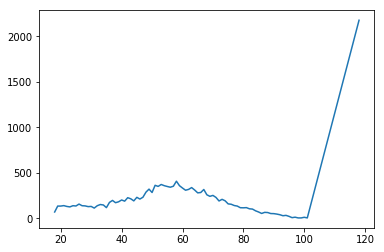

In [12]:
plt.plot(profile.age.value_counts().sort_index())

In [11]:
profile['age_new'] = profile.age.apply(lambda x: x if x <= 80 else None)
profile.head(30)
# highly correlated with na income

,age,became_member_on,gender,id,income,age_new
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,55.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,75.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,68.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,65.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN,NaN


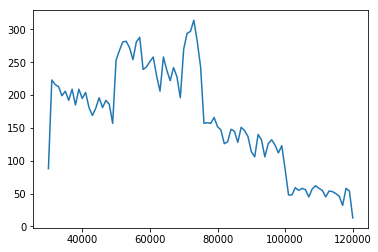

In [12]:
plt.plot(profile.income.value_counts().sort_index())

In [13]:
profile.gender.value_counts(dropna = False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

## transcript

In [14]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [16]:
transcript[transcript.event == 'offer received'].time.value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

In [17]:
transcript.value.head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [18]:
# all possible keys

all_keys = set()

for row in range(transcript.shape[0]):
    all_keys = all_keys.union(transcript.value.iloc[row].keys())

In [19]:
all_keys

{'amount', 'offer id', 'offer_id', 'reward'}

In [20]:
def get_dict_val(orig_val, key):
    try:
        res = orig_val[key]
    except:
        res = None
    return res

In [21]:
transcript['offer id'] = transcript.value.apply(lambda x: get_dict_val(x, 'offer id'))
transcript['offer_id'] = transcript.value.apply(lambda x: get_dict_val(x, 'offer_id'))
transcript['reward'] = transcript.value.apply(lambda x: get_dict_val(x, 'reward'))
transcript['amount'] = transcript.value.apply(lambda x: get_dict_val(x, 'amount'))

In [22]:
# so we can combine the 2 col
transcript[(~transcript['offer id'].isnull()) & (~transcript['offer_id'].isnull())]

,event,person,time,value,offer id,offer_id,reward,amount


In [23]:
transcript['offer_id'] = transcript['offer id'].fillna('').astype('str') + transcript['offer_id'].fillna('').astype('str')

In [24]:
transcript.drop('offer id', axis = 1, inplace=True)

In [25]:
transcript.head()

,event,person,time,value,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### How many of them completed the offer without receiving/seeing the offer

In [46]:
user_offer_pair_complete = transcript.loc[transcript.event == 'offer completed', ['person', 'offer_id']].drop_duplicates()
print('has ', user_offer_pair_complete.shape[0], ' rows')

has  28996  rows


In [47]:
user_offer_pair_complete['indicator'] = 1

In [39]:
# user_offer_pair_view = transcript.loc[transcript.event == 'offer viewed', ['person', 'offer_id']].drop_duplicates()
# print('has ', user_offer_pair_view.shape[0], ' rows')

In [40]:
user_offer_pair_receive = transcript.loc[transcript.event == 'offer received', ['person', 'offer_id']].drop_duplicates()
print('has ', user_offer_pair_receive.shape[0], ' rows')

has  63288  rows


In [51]:
pd.merge(user_offer_pair_complete, user_offer_pair_complete, how = 'left')['indicator'].sum()

28996

# Predict whether they will view it

since we do not have data of the users who are not part of this promotion experiment, we won't be able to compare whether these offers actually brings more revenue. 

but we can compare what demographic groups have a higher possibility to view the offer.

assuming the possibility of an offer being viewed is irrelavant of what type of offer it is

In [52]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [53]:
transcript[(transcript.event == 'offer viewed') & (~transcript.reward.isnull())]

,event,person,time,value,offer_id,reward,amount


In [54]:
transcript_received = transcript[transcript.event == 'offer received'].copy()

In [55]:
transcript_received.shape

(76277, 7)

In [56]:
transcript_received.person.nunique()

16994

In [57]:
transcript_viewed = transcript[transcript.event == 'offer viewed'].copy()

In [58]:
transcript_viewed.shape

(57725, 7)

In [59]:
transcript_viewed.person.nunique()

16834

double check if there are viewed records with no received records

In [60]:
transcript_viewed[~transcript_viewed.person.isin(transcript_received.person.unique())]

,event,person,time,value,offer_id,reward,amount


check duplicates: same offer sent to same person multiple times? and multiple views? can't identify which one they saw, so just drop duplicates and not using time

In [61]:
transcript_received[transcript_received.duplicated(subset = ['event','person', 'offer_id'], keep = False)].sort_values(['person', 'offer_id'])

,event,person,time,value,offer_id,reward,amount
56475,offer received,00116118485d4dfda04fdbaba9a87b5c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
248359,offer received,00116118485d4dfda04fdbaba9a87b5c,576,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
1889,offer received,0020c2b971eb4e9188eac86d93036a77,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
112698,offer received,0020c2b971eb4e9188eac86d93036a77,336,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
55857,offer received,003d66b6608740288d6cc97a6903f4f0,168,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
158081,offer received,003d66b6608740288d6cc97a6903f4f0,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
159010,offer received,00426fe3ffde4c6b9cb9ad6d077a13ea,408,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
253486,offer received,00426fe3ffde4c6b9cb9ad6d077a13ea,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
163335,offer received,004c5799adbf42868b9cff0396190900,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
214247,offer received,004c5799adbf42868b9cff0396190900,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN


In [62]:
transcript_viewed[transcript_viewed.person == '0020c2b971eb4e9188eac86d93036a77']

,event,person,time,value,offer_id,reward,amount
18431,offer viewed,0020c2b971eb4e9188eac86d93036a77,12,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
174774,offer viewed,0020c2b971eb4e9188eac86d93036a77,426,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
293372,offer viewed,0020c2b971eb4e9188eac86d93036a77,660,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,NaN


In [63]:
transcript_received.drop_duplicates(subset=['person', 'offer_id'], inplace = True)

In [64]:
transcript_received.shape

(63288, 7)

In [65]:
transcript_viewed.drop_duplicates(subset=['person', 'offer_id'], inplace = True)

In [66]:
transcript_viewed.shape

(49135, 7)

In [67]:
df_viewed = pd.merge(transcript_received.drop(['event', 'value', 'reward', 'amount'], axis=1), 
         transcript_viewed.drop(['event', 'value', 'reward', 'amount'], axis = 1), 
         how = 'left',
         left_on = ['person', 'offer_id'], 
         right_on = ['person', 'offer_id'], 
         suffixes=('_recv', '_view'))

In [68]:
df_viewed.head()

,person,time_recv,offer_id,time_view
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6.0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,18.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,12.0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,84.0


In [69]:
# df_viewed.event_view.isnull().sum()

In [70]:
df_viewed.shape

(63288, 4)

In [71]:
df_viewed['is_viewed'] = np.where(df_viewed.time_view.isnull(),0,1)

In [72]:
df_viewed.head()

,person,time_recv,offer_id,time_view,is_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0,1
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6.0,1
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,18.0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,12.0,1
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,84.0,1


In [73]:
df_viewed.offer_id.nunique()

10

In [74]:
df_viewed = df_viewed.drop(['time_recv', 'time_view'], axis = 1)

In [75]:
portfolio

,difficulty,duration,id,reward,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_discount,type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [76]:
# drop some column because if won't affect user behavior until the offer is viewed
portfolio_copy = portfolio.drop(['difficulty', 'duration','reward', 'type_bogo', 'type_discount', 'type_informational'], axis = 1).copy()

In [77]:
portfolio_copy

,id,ch_web,ch_email,ch_mobile,ch_social
0,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [78]:
portfolio.drop(['difficulty', 'duration','reward'], axis = 1)

,id,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_discount,type_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


In [79]:
profile.head()

,age,became_member_on,gender,id,income,age_new
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,55.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,75.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,NaN


In [184]:
profile_copy = profile.dropna().copy()

In [185]:
profile_copy.head()

,age,became_member_on,gender,id,income,age_new
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,55.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,75.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,68.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,65.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,58.0


In [186]:
tenure_bins = np.array([20130101, 20151231, 20161231, 20171231, 20181231])

In [187]:
profile_copy['tenure_bins'] = pd.cut(profile_copy.became_member_on, tenure_bins, labels = ['join_13_15', 'join_16', 'join_17', 'join_18'])

In [188]:
profile_copy.head()

,age,became_member_on,gender,id,income,age_new,tenure_bins
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,55.0,join_17
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,75.0,join_17
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,68.0,join_18
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,65.0,join_18
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,58.0,join_17


In [189]:
profile_copy.tenure_bins.value_counts()

join_17       5235
join_18       3452
join_16       2770
join_13_15    2382
Name: tenure_bins, dtype: int64

In [190]:
profile_copy = pd.concat([profile_copy, pd.get_dummies(profile_copy.gender, prefix='gen')], axis = 1).drop(['age', 'became_member_on', 'gender', 'gen_M'], axis = 1)

In [191]:
profile_copy = pd.concat([profile_copy, pd.get_dummies(profile_copy.tenure_bins, prefix='ten')], axis = 1).drop(['tenure_bins', 'ten_join_18'], axis = 1)

In [192]:
profile_copy.head()

,id,income,age_new,gen_F,gen_O,ten_join_13_15,ten_join_16,ten_join_17
1,0610b486422d4921ae7d2bf64640c50b,112000.0,55.0,1,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,75.0,1,0,0,0,1
5,e2127556f4f64592b11af22de27a7932,70000.0,68.0,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,65.0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,58.0,0,0,0,0,1


In [89]:
df_viewed.head()

,person,offer_id,is_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,1


In [90]:
portfolio_copy

,id,ch_web,ch_email,ch_mobile,ch_social
0,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


## Train model

In [193]:
dataset = pd.merge(pd.merge(df_viewed, portfolio_copy, left_on = 'offer_id', right_on = 'id').drop(['offer_id', 'id'], axis = 1)
         , profile_copy
         , left_on = 'person'
         , right_on = 'id').drop(['person', 'id'], axis = 1)

In [194]:
dataset.head()

,is_viewed,ch_web,ch_email,ch_mobile,ch_social,income,age_new,gen_F,gen_O,ten_join_13_15,ten_join_16,ten_join_17
0,1,1,1,1,0,100000.0,75.0,1,0,0,0,1
1,1,1,1,1,1,100000.0,75.0,1,0,0,0,1
2,1,0,1,1,1,100000.0,75.0,1,0,0,0,1
3,1,0,1,1,1,100000.0,75.0,1,0,0,0,1
4,1,1,1,1,0,41000.0,59.0,0,0,1,0,0


In [218]:
# because it ten_join_17 is not significant
dataset.drop('ten_join_17', axis = 1, inplace = True)
# because it ten_join_13_15, ten_join_16 is not practically significant
dataset.drop(['ten_join_13_15', 'ten_join_16'], axis = 1, inplace = True)
# because not enough practical significance
# ref: https://towardsdatascience.com/a-simple-interpretation-of-logistic-regression-coefficients-e3a40a62e8cf
dataset.drop(['gen_F'], axis = 1, inplace = True)

In [220]:
dataset.head()

,is_viewed,ch_web,ch_mobile,ch_social,income,age_new,gen_O
0,1,1,1,0,100000.0,75.0,0
1,1,1,1,1,100000.0,75.0,0
2,1,0,1,1,100000.0,75.0,0
3,1,0,1,1,100000.0,75.0,0
4,1,1,1,0,41000.0,59.0,0


In [222]:
# ALL 1
dataset.drop('ch_email', axis = 1, inplace = True)

In [223]:
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

Train Test Split

In [224]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Feature Scaling

In [225]:
# not necessary but helpful to plot
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

train

In [226]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 200)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=200, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

pred

In [227]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [1 1]
 [1 1]
 ..., 
 [1 1]
 [1 1]
 [1 1]]


### evaluation

In [228]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1166 1856]
 [ 644 9225]]


0.80606624776976188

In [229]:
precision_score(y_test, y_pred)

0.8325060915079866

In [230]:
recall_score(y_test, y_pred)

0.93474516161718513

In [231]:
f1_score(y_test, y_pred)

0.88066825775656321

Feature: 0, Score: 0.46140
Feature: 1, Score: 0.23714
Feature: 2, Score: 1.56547
Feature: 3, Score: 0.12654
Feature: 4, Score: 0.08039
Feature: 5, Score: 0.08733


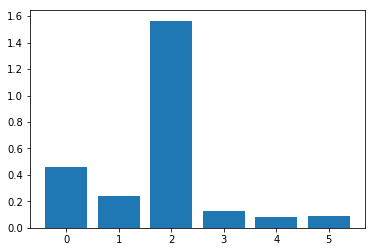

In [232]:
# https://pythonguides.com/scikit-learn-logistic-regression/
from matplotlib import pyplot
importance = classifier.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [233]:
# import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import pandas as pd
# X = dataset.iloc[:, 1:]
# y = dataset.iloc[:, 0]

model = sm.Logit(y_test, sm.add_constant(X_test))
results = model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.394253
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            No. Iterations:   7.0000    
Dependent Variable: y                Pseudo R-squared: 0.276     
Date:               2022-02-13 21:15 AIC:              10178.6326
No. Observations:   12891            BIC:              10230.8826
Df Model:           6                Log-Likelihood:   -5082.3   
Df Residuals:       12884            LL-Null:          -7020.1   
Converged:          1.0000           Scale:            1.0000    
--------------------------------------------------------------------
         Coef.     Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const    1.8024      0.0362    49.8112    0.0000    1.7315    1.8733
x1       0.5158      0.0408    12.6449    0.0000    0.4359    0.5958
x2       0.2649      0.0198    13.3948    0.0000    0.2262    0.3037
x3       1.5586      0.0422    36.9101    0.0000    1.4758    1.6413
x4       0.1334      0.0264     5.0465    0.0000    0.0816    0.1852
x5       0.0800      0.0257     3.1137    0.0018    0.0297    0.1304
x6       0.1007      0.0273     3.6856    0.0002    0.0471    0.1542
=================================================================

"""

In [234]:
print(classifier.intercept_)
print(classifier.coef_[0])

[ 1.82528493]
[ 0.46140149  0.23713968  1.56547026  0.12654066  0.08039455  0.0873291 ]


# Predict if they viewed it, how likely they will complete it

First need to exclude offer completed without viewing it, or before it's viewed

In [239]:
transcript.head()

,event,person,time,value,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [251]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [247]:
df_first_viewed = transcript[transcript.event == 'offer viewed'].groupby(['person', 'offer_id'])['time'].min().reset_index()

In [264]:
df_first_viewed.head()

,person,offer_id,time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,216


In [274]:
df_completed = transcript[transcript.event == 'offer completed'].copy()

In [275]:
df_completed[df_completed.duplicated(['person', 'offer_id'], keep = False)].sort_values('person')

,event,person,time,value,offer_id,reward,amount
31327,offer completed,0020c2b971eb4e9188eac86d93036a77,54,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
218936,offer completed,0020c2b971eb4e9188eac86d93036a77,510,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
144668,offer completed,003d66b6608740288d6cc97a6903f4f0,384,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
216735,offer completed,003d66b6608740288d6cc97a6903f4f0,504,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
239694,offer completed,004c5799adbf42868b9cff0396190900,558,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN
87420,offer completed,004c5799adbf42868b9cff0396190900,222,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
258607,offer completed,004c5799adbf42868b9cff0396190900,576,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
177710,offer completed,004c5799adbf42868b9cff0396190900,432,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN
295666,offer completed,00715b6e55c3431cb56ff7307eb19675,666,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,NaN
84520,offer completed,00715b6e55c3431cb56ff7307eb19675,210,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,NaN


In [276]:
df_completed[df_completed.duplicated(['person', 'offer_id', 'time'], keep = False)]

,event,person,time,value,offer_id,reward,amount
66122,offer completed,3dde94fa581145cb9f206624f1a94d5a,168,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN
66123,offer completed,3dde94fa581145cb9f206624f1a94d5a,168,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN
66782,offer completed,e9fb6ed2cecb4980ba98c86abc9c91e3,168,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN
66783,offer completed,e9fb6ed2cecb4980ba98c86abc9c91e3,168,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN
67613,offer completed,a7dc060f6fc94ca7bf71fbb188187dca,168,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN
67614,offer completed,a7dc060f6fc94ca7bf71fbb188187dca,168,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN
68561,offer completed,30478a4c1e884a63a822aa87b833ed7a,168,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,NaN
68562,offer completed,30478a4c1e884a63a822aa87b833ed7a,168,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,NaN
69217,offer completed,84fb57a7fe8045a8bf6236738ee73a0f,168,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN
69218,offer completed,84fb57a7fe8045a8bf6236738ee73a0f,168,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN


In [277]:
df_completed.drop_duplicates(['person', 'offer_id', 'time'], inplace = True)

In [298]:
df_comp_view = pd.merge(df_completed, df_first_viewed, 
                        how = 'left',
                        left_on=['person', 'offer_id'], right_on=['person', 'offer_id'])

In [299]:
df_comp_view.shape

(33182, 8)

In [300]:
df_comp_view.head()

,event,person,time_x,value,offer_id,reward,amount,time_y
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN,0.0
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,6.0
2,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,0.0
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN,0.0
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,0.0


In [301]:
df_comp_view = df_comp_view.loc[~((df_comp_view.time_y.isnull()) | (df_comp_view.time_x < df_comp_view.time_y))]

In [303]:
df_comp_view

,event,person,time_x,value,offer_id,reward,amount,time_y
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN,0.0
2,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,0.0
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN,0.0
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,0.0
5,offer completed,227f2d69e46a4899b70d48182822cff6,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,0.0
7,offer completed,d72d201be5794279aa716d8ad82b8d90,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,0.0
8,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN,0.0
9,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,0.0
16,offer completed,c3321bc76743445c9103eef0ce9d833b,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,NaN,0.0
19,offer completed,5152fa6375184287b06e2fd0d5abed34,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,0.0


In [307]:
df_comp_view[df_comp_view.duplicated(['person', 'offer_id'], keep = False)].sort_values('person')

,event,person,time_x,value,offer_id,reward,amount,time_y
21010,offer completed,0020c2b971eb4e9188eac86d93036a77,510,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,12.0
2304,offer completed,0020c2b971eb4e9188eac86d93036a77,54,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,12.0
20682,offer completed,003d66b6608740288d6cc97a6903f4f0,504,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,300.0
13137,offer completed,003d66b6608740288d6cc97a6903f4f0,384,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,300.0
16317,offer completed,004c5799adbf42868b9cff0396190900,432,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,408.0
25641,offer completed,004c5799adbf42868b9cff0396190900,576,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,174.0
7689,offer completed,004c5799adbf42868b9cff0396190900,222,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,174.0
24652,offer completed,004c5799adbf42868b9cff0396190900,558,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,408.0
12075,offer completed,0082fd87c18f45f2be70dbcbb0fb8aad,366,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,348.0
17695,offer completed,0082fd87c18f45f2be70dbcbb0fb8aad,450,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,348.0


In [309]:
df_comp_view.drop_duplicates(['person', 'offer_id'], inplace = True)

In [317]:
df_comp_view = df_comp_view[['person', 'offer_id']].copy()

In [318]:
df_comp_view.duplicated().sum()

0

In [319]:
df_comp_view.head()

,person,offer_id
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5
2,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0
5,227f2d69e46a4899b70d48182822cff6,4d5c57ea9a6940dd891ad53e9dbe8da0


In [320]:
df_comp_view['is_completed'] = 1

In [321]:
df_comp_view.head()

,person,offer_id,is_completed
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,1
2,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,1
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,1
5,227f2d69e46a4899b70d48182822cff6,4d5c57ea9a6940dd891ad53e9dbe8da0,1


In [325]:
df_viewed = pd.merge(df_first_viewed, df_comp_view, 
         how = 'left',
         left_on=['person', 'offer_id'], right_on = ['person', 'offer_id'])

In [328]:
df_viewed['is_completed'] = df_viewed.is_completed.fillna(0)

In [329]:
df_viewed.head()

,person,offer_id,time,is_completed
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,0.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,0.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,0.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540,0.0
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,216,0.0


In [330]:
df_viewed.is_completed.value_counts()

0.0    27763
1.0    21372
Name: is_completed, dtype: int64